In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt

import os
from netCDF4 import Dataset

# Import and apply style file for plots
plt.style.use("mpl.style")

# Model

The evolution of major axis length a(t) and parameter sigma(t) wrt time are described by a system of coupled ODEs:

$\frac{d\sigma}{dt}=\sigma^2\frac{b^2-a^2}{a^2+b^2}$

$\frac{da}{dt}=\sigma a$

where a and b are related by the assumption of incompressibility:

$ab={r^2}$

# Functions

In [2]:
#Compile all filenames (value) and properties (key) into a dictionary
def generate_file_names(filepath):
    data_files = {}

    for file in os.listdir(filepath):

        #Remove the .nc extension
        #Collect the info for the run in an array
        file_info = file.split(".")
        file_info = file_info[0].split("_")

        #File name
        file_name = file

        #Add the files to datafiles dictionary
        data_files[(file_info[0],file_info[1],file_info[2])]= filepath + "/" + file_name
    return data_files

In [3]:
#x is a vector of initial conditions
#t is the only independent variable

def odes(X,t):
    
    #Assign each variable its initial condition
    a = X[0]
    sigma = X[1]
    
    #Relationship between a and b
    b = r**2/a
    
    #Define ODEs
    da_dt = sigma*a
    dsig_dt = sigma**2*((b**2-a**2)/(a**2+b**2))
    
    
    
    return [da_dt,dsig_dt]

In [4]:
#Return the analytical values of major axis length and kinetic energy wrt t

def analyt_soltn_values(t, init_conditions, mp):
    #Use scipy odeint to solve odes and return time profiles of sigma and a
    X = odeint(odes,init_conditions,t) #Array of sigma and a values over time
    #Extract a and sigma time profiles
    a = X[:,0] #
    b = 25/a
    sigma = X[:,1]
    #Calculate kinetic energy
    E_k = 0.5*mp*sigma**2*(4/3*a*b)*(a**2+b**2)
    
    return a,E_k

In [5]:
#Return the numerical values of major axis length and kinetic energy wrt t

def simulation_values(t, mp, xd, vxd, vyd):
    
    #Major axis value from data
    a_data = np.max(xd, axis=1)
    
    #Kinetic energy from data
    Exd = 0.5*mp*(np.sum(np.abs(vxd), axis=1))**2
    Eyd = 0.5*mp*(np.sum(np.abs(vyd), axis=1))**2
    E_tot = Exd+Eyd

    return a_data, E_tot

In [16]:
def benchmark(data_files):
    
    fig, ax = plt.subplots(2,1,figsize=(15,15),sharex=True)
    all_run_info = []

    for run in data_files:
        
        #Extract run conditions from file names
        run_info = list(run)[0:2]
        var_0 = int(run_info[0])
        var_1 = int(run_info[1])
        run_info[0]=var_0_key[var_0]
        run_info[1]=var_1_key[var_1][0]
        
        #Scaling variables (depend on run conditions)
        sf = 1/int(list(run)[2]) #Scaling of unit cell
        run_info.append(sf)
        L_z = h3*(d-2)*sf #Account for L_z iff d=3
        n = 1/sf**d #Number density - number of particles per volume
        mp = rho_0/n #Mass of particles (density is constant)
#         if d == 3:
#             N = L_x*L_y*L_z/sf**d # Total number of atoms
#         elif d == 2:
#             N = L_x*L_y/sf**d

        #Extract data from netcdf file
        ds = Dataset(data_files[run])
        td = ds["time"][:]
        xd = ds['coordinates'][:,:,0] #At timestep nf, for all particles, x position
        yd = ds["coordinates"][:,:,1] #At timestep nf, for all particles, y position
        vxd = ds["velocities"][:,:,0] #At timestep nf, for all particles, x position
        vyd = ds['velocities'][:,:,1] #At timestep nf, for all particles, y velocity
       
        
        #Calculations and data needed for benchmarks
        init_conditions = [r, sigma0]
        a_ref, E_k_ref = analyt_soltn_values(td, init_conditions, mp)
        a_data, E_k_data = simulation_values(td, mp, xd, vxd, vyd)
        
        #Benchmark semi-major axis length
        ax[0].plot(td, a_data/a_data[0],linestyle=sf_key[sf],
                       color=var_1_key[var_1][1], label = run_info[0:3])
        ax[0].plot(td, a_ref/a_ref[0],"r",label ="Analytical Solution")
        ax[0].legend(bbox_to_anchor=(1,1), loc="upper left")
        ax[0].set_ylabel("a")

        
        #Benchmark kinetic energy
        ax[1].plot(td, E_k_data/E_k_data[0],linestyle=sf_key[sf],
                       color=var_1_key[var_1][1], label = run_info[0:3])
        ax[1].plot(td, E_k_ref/E_k_ref[0],"r:",label ="Analytical Solution")
        ax[1].legend(bbox_to_anchor=(1,1), loc="upper left")
        ax[1].set_ylabel(r"$E_K$")
        ax[1].set_xlabel("t")
    
    plt.tight_layout()

# Test Cases

## Extending Droplet

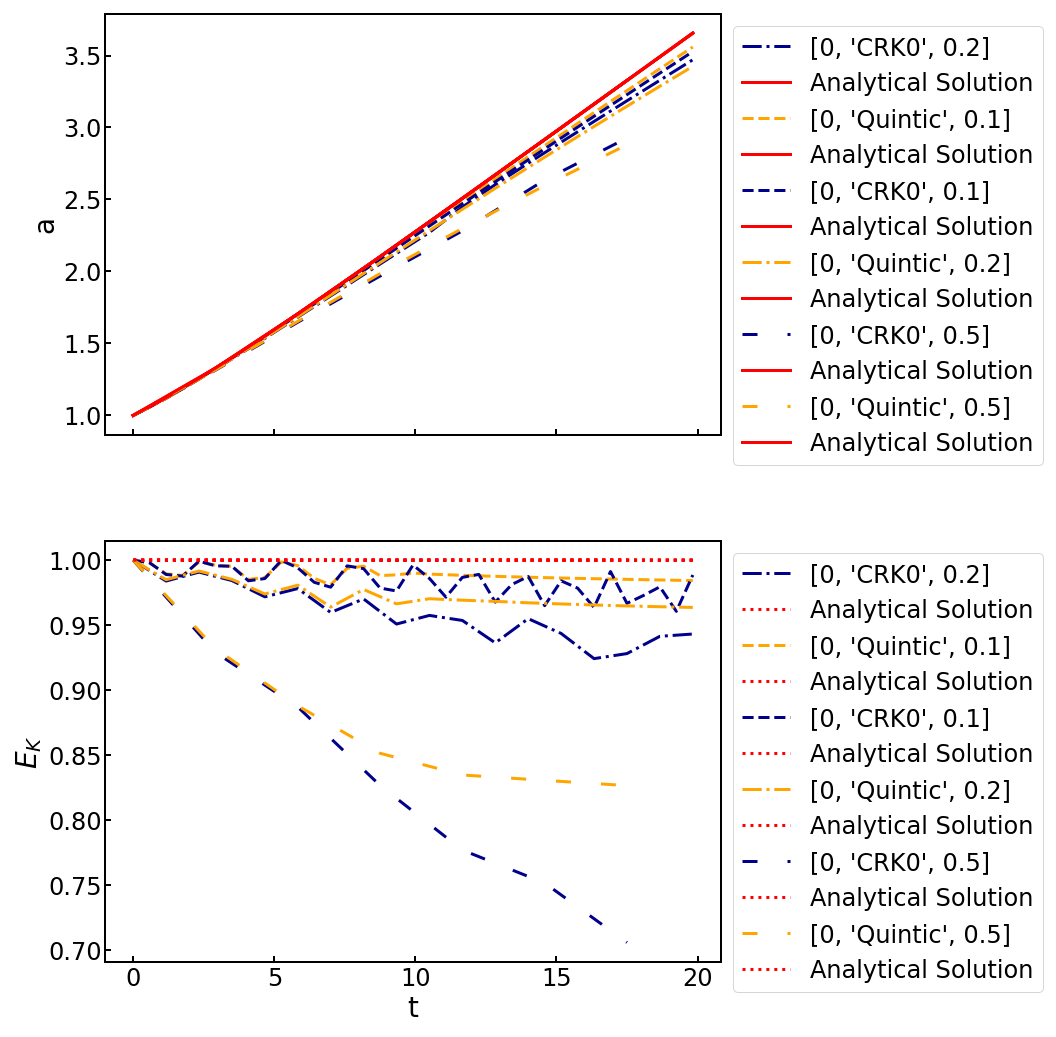

In [15]:
#---System Properties---#

d = 2 #System dimensions
r = 5 #drop radius
h3 = 3.5 #Smoothing length coefficient

eta = 0.01 #dynamic viscosity
rho_0 = 1 #initial density
nu = eta/rho_0 #kinetic viscosity

sigma0 = 0.1 #Decay timescale


#---Keys for Stylizing the Plot---#
var_0_key = {0:0,100:0.01} #Viscosity
var_1_key = {0:["CRK0", "darkblue"], 1:["CRK1","orange"], 2:["CRK2","darkblue"],5:["Quintic","orange"]} #CRK or quintic
sf_key = {0.05:"-",0.1:"--",0.2:"-.",0.25:":",0.5:(0,(5,10))}

###Data Files###
filepath = '/home/epalermo/dev/test/droplet_extension/data_files/zero_viscosity'
benchmark(generate_file_names(filepath))